## ImageNet Image Retreival and Concept Logic with Resnet50
In this notebook, we provide another use-case of our method.
We use a Resnet50 model (pre-trained on ImageNet) and leverage Text-To-Concept to:
+ Image Retrieval: finding images which have some concepts (e.g., "a bear in trees").
+ Concept Logic: finding some particualr images that have some concepts while other concepts are not present. (e.g., an <span style="color: orange;"><b>orange</b></span> <b>cat</b> which is <b>not indoors</b>).

This notebook has these sections:
+ <i>Preliminaries</i>: we import required libraries and load transformations.
+ <i>Resnet50</i>: we load the model and implement its necessary functions, enabling us to use `TextToConcept`.
+ <i>Linear Aligner</i>: we initiate `TextToConcept` object and load its linear aligner.
+ <i>Evaluation on ImageNet</i>: we load ImageNet and visualize retrieved images:
    + <i>Text Retrieval</i>: we use methods implemented in `TextToConcept` to obtain relevant images.
    + <i>Concept Logic</i>: we use methods implemented in `TextToConcept` to collect particular images.

### Preliminaries
In this section, we import the required libraries and initialize standard transformations necessary for loading datasets. It is worth mentioning that certain models require input normalization, while others do not.

In [1]:
%load_ext autoreload
%autoreload 2
import torch
import torchvision
import numpy as np
from tqdm import tqdm
from TextToConcept import TextToConcept

In [2]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
std_transform_without_normalization = torchvision.transforms.Compose([
    torchvision.transforms.Resize(224),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor()])


std_transform_with_normalization = torchvision.transforms.Compose([
    torchvision.transforms.Resize(224),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(), 
    torchvision.transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)])

In [ ]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def visualize_top_images(inds, k=8, nrow=2):

    transform = torchvision.transforms.Compose(
        [torchvision.transforms.Resize(256),
         torchvision.transforms.CenterCrop(224),
         torchvision.transforms.ToTensor()])

    dset2 = torchvision.datasets.ImageNet(root='/fs/cml-datasets/ImageNet/ILSVRC2012',
                                     split='train',
                                     transform=transform)


    f, ax = plt.subplots(figsize=(17,5))
    ax.set_axis_off()
    _ = [ax.spines[x].set_visible(False) for x in ['top', 'right', 'bottom', 'left']]
    top_images = [dset2[i][0] for i in inds[:k]]

    grid = make_grid(top_images, nrow=nrow).numpy().swapaxes(0,1).swapaxes(1,2)
    ax.imshow(grid)
    plt.show()
    plt.close()

### Resnet50
In this part, we load Resnet50 model.
In order to use ``TextToConcept`` framework, model should implement these functions/attributes:
+ ``forward_features(x)`` that takes a tensor as the input and outputs the representation (features) of input $x$ when it is passed through the model.
+ ``get_normalizer`` should be the normalizer that the models uses to preprocess the input. e.g., Resnet18, uses standard ImageNet normalizer.
+ Attribute ``has_normalizer`` should be `True` when normalizer is need for the model.

In [5]:
model = torchvision.models.resnet50(pretrained=True)

encoder = torch.nn.Sequential(*list(model.children())[:-1])
model.forward_features = lambda x : encoder(x)
model.get_normalizer = torchvision.transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
model.has_normalizer = True

/cmlscratch/krezaei/p38/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/cmlscratch/krezaei/p38/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Linear Aligner

<b>Initiating Text-To-Concept Object</b><br>
In this section, we initiate ``TextToConcept`` object which turns the vision encoder (e.g., Resnet50) into a model capable of integrating language and vision. By doing so, we enable the utilization of certain abilities present in vision-language models.

In [53]:
text_to_concept = TextToConcept(model)

<b>Loading the Linear Aligner</b><br>
We can also use an already existing linear aligner, to do so, we use the function ``load_linear_aligner``.

In [54]:
path = '/cmlscratch/krezaei/alignment/extensive_alignment/matrices/pytorch_resnet50-clip_ViT-B_16.pth'
text_to_concept.load_linear_aligner(path)

### Evaluation on ImageNet

In [55]:
dset = torchvision.datasets.ImageNet(root='/fs/cml-datasets/ImageNet/ILSVRC2012',
                                     split='val',
                                     transform=std_transform_without_normalization)

<b>Text Retrieval</b><br>
In this section, we search for prompt 
`"polka-dotted"`.

In [56]:
templates = ['itap of a {}', 'a bad photo of the {}', 'a origami {}', 'a photo of the large {}',
             'a {} in a video game', 'art of the {}', 'a photo of the small {}']

In [59]:
sorted_inds, sims = text_to_concept.search(
    dset=dset,
    prompts=[prompt.format('polka-dotted') for prompt in templates])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6250/6250 [03:06<00:00, 33.54it/s]


<b>Visualization</b><br>
Visualization of top images:

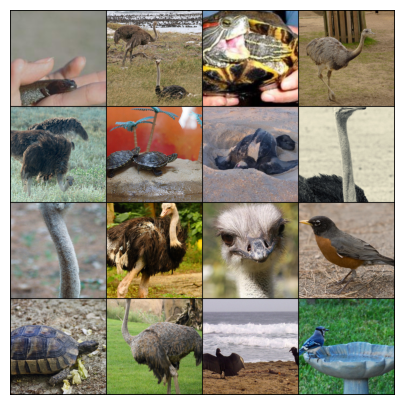

In [60]:
visualize_top_images(sorted_inds, 16, 4)

In [36]:
indices, _ = text_to_concept.concept_logic(
    dset=dset,
    list_of_prompts=[[template.format(c) for template in templates] for c in ['a dog', 'the beach', 'the sunset']],
    signs=[1, 1, 1],
    scales=[1.8, 1.5, 1.5])

print(f'number of retrieved images: {len(indices)}')

True


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6250/6250 [03:05<00:00, 33.62it/s]

number of retrieved images: 6


<b>Visualization</b><br>
Visualization of top images:

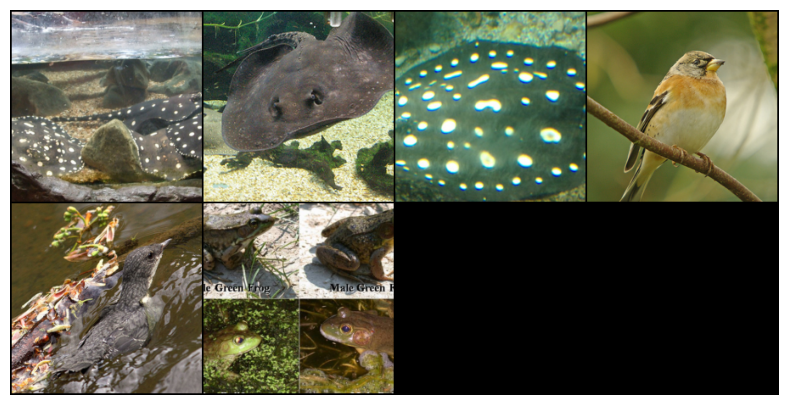

In [38]:
visualize_top_images(indices, 6, 2)

In [14]:

indices, _ = text_to_concept.concept_logic(
    dset=dset,
    list_of_prompts=[[template.format(c) for template in templates] for c in ['a cat', 'orange', 'indoors']],
    signs=[1, 1, -1],
    scales=[3, 2, 0])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:02<00:00, 60.96it/s]


In [10]:
visualize_top_images(indices, 2, 1)

array([ 5, 12, 21])